## Marjan Farsi - Group 12 - Storm Dataset (2020 - 2025)- Group Project Task 3 - Dist. Computing

### Analyzes tornado activity across the United States using the storm_g2020.csv dataset.
### Query : Map or group by state (or region) to compare: 
-  ### which states see more tornadoes and 
-  ### which states see more severe tornadoes.

In [19]:
sc.stop()

Marjan Code:

--- Number of TORNADOES Per State (descending order) ---


COLORADO 231
ALABAMA 543
OHIO 265
SOUTH DAKOTA 111
SOUTH CAROLINA 211
VIRGINIA 71
WEST VIRGINIA 27
TEXAS 663
LOUISIANA 337
WYOMING 34
NEW HAMPSHIRE 7
DISTRICT OF COLUMBIA 2
RHODE ISLAND 7
KANSAS 258
FLORIDA 365
MARYLAND 56
NEW JERSEY 41
MASSACHUSETTS 19
PUERTO RICO 5
IDAHO 7
NORTH CAROLINA 175
OKLAHOMA 505
NEW MEXICO 55
NEW YORK 74
CONNECTICUT 20
ALASKA 1
WISCONSIN 202
NEBRASKA 314
DELAWARE 13
ARKANSAS 285
GEORGIA 348
INDIANA 247
CALIFORNIA 34
ARIZONA 31
MISSISSIPPI 660
KENTUCKY 259
MINNESOTA 282
NORTH DAKOTA 77
MAINE 2
OREGON 13
UTAH 8
TENNESSEE 281
IOWA 477
WASHINGTON 13
MONTANA 17
VERMONT 4
MICHIGAN 92
PENNSYLVANIA 128
MISSOURI 334
ILLINOIS 607
NEVADA 3


Marjan Code:

--- Number of SEVERE TORNADOES Per State (descending order) ---

TEXAS: 22
MISSISSIPPI: 19
OKLAHOMA: 17
TENNESSEE: 17
ALABAMA: 16
GEORGIA: 15
KENTUCKY: 13
LOUISIANA: 11
ARKANSAS: 10
MISSOURI: 10
NORTH CAROLINA: 7
INDIANA: 6
SOUTH CAROLINA: 5
FLORIDA: 5
IOWA: 5
PENNSYLVANIA: 5
MICHIGAN: 5
ILLINOIS: 4
OHIO: 3
SOUTH DAKOTA: 2
WYOMING: 1
NEW JERSEY: 1
NEW YORK: 1
DELAWARE: 1
MINNESOTA: 1


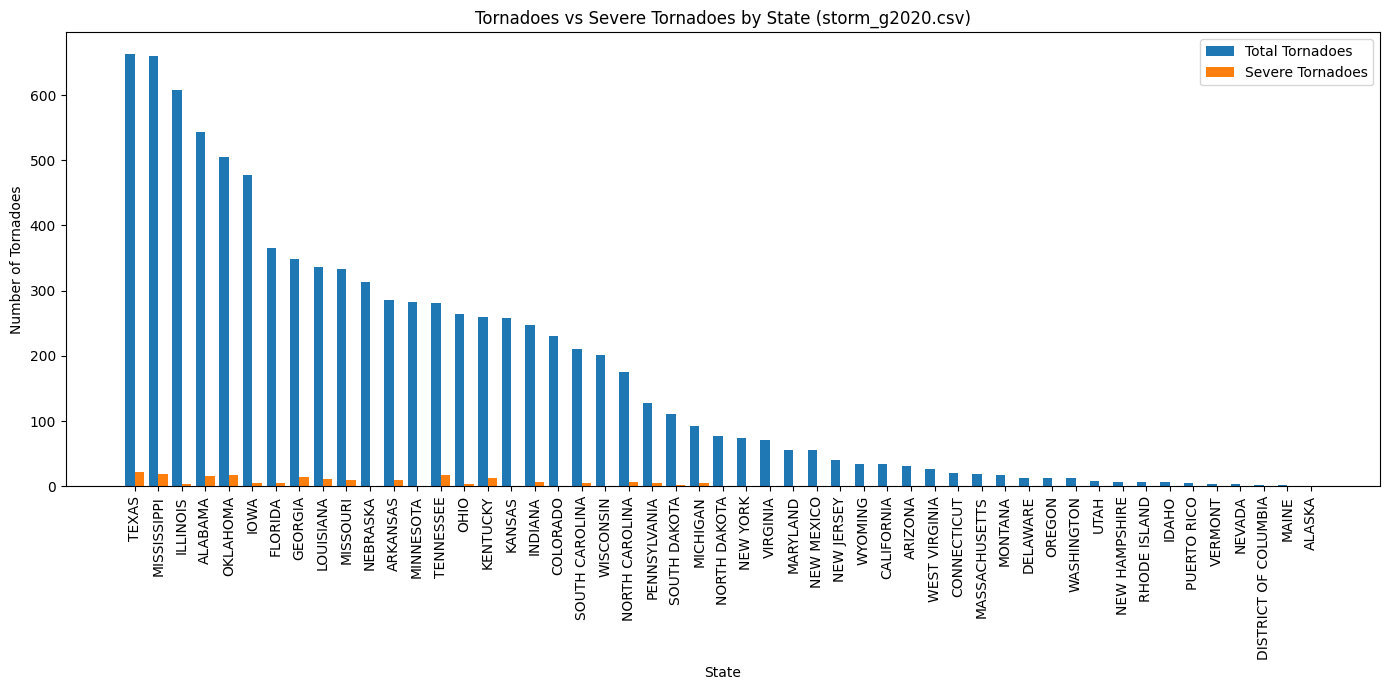

In [20]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
import numpy as np

sc = SparkContext("local", "Storm_Tornado_Analysis")

rdd = sc.textFile("storm_g2020.csv")

header = rdd.first()
columns = header.split(",")

rdd = rdd.filter(lambda row: row != header)
split_rdd = rdd.map(lambda line: line.split(","))


# Get columns indexes

event_type_idx = columns.index("EVENT_TYPE")
state_idx = columns.index("STATE")

damage_prop_idx = columns.index("DAMAGE_PROPERTY")
damage_crop_idx = columns.index("DAMAGE_CROPS")

deaths_direct_idx = columns.index("DEATHS_DIRECT")
deaths_indirect_idx = columns.index("DEATHS_INDIRECT")
inj_direct_idx = columns.index("INJURIES_DIRECT")
inj_indirect_idx = columns.index("INJURIES_INDIRECT")


# Clean missing data and convert data to appropriate datatypes

def safe_float(x):
    try:
        return float(x)
    except:
        return 0.0

def safe_int(x):
    try:
        return int(x)
    except:
        return 0

def fill_and_cast(record):
    # Replace missing state or event type
    record[event_type_idx] = record[event_type_idx] or "Unknown"
    record[state_idx] = record[state_idx] or "Unknown"
    return record

clean_rdd = split_rdd.map(fill_and_cast)


# Filter only Tornado events

tornado_rdd = clean_rdd.filter(lambda x: x[event_type_idx] == "Tornado")


# Count total Tornados by states

tornado_count = (
    tornado_rdd
    .map(lambda x: (x[state_idx], 1))
    .reduceByKey(lambda a, b: a + b)
)
print("Marjan Code:")
print("\n--- Number of TORNADOES Per State (descending order) ---")
for state, count in tornado_count.collect():
    print(state, count)


# Combine different severity indicators (Define severe tornado rule)

'''
Indicators of severity, including:

    - Property damage
    - Crop damage
    - Direct & indirect deaths
    - Direct & indirect injuries
'''
def is_severe(record):
    prop = safe_float(record[damage_prop_idx])
    crop = safe_float(record[damage_crop_idx])
    deaths = safe_int(record[deaths_direct_idx]) + safe_int(record[deaths_indirect_idx])
    injuries = safe_int(record[inj_direct_idx]) + safe_int(record[inj_indirect_idx])

    return (prop > 50000) or (crop > 50000) or (deaths > 0) or (injuries > 5)


# Filter severe tornados based on the above rule

severe_rdd = tornado_rdd.filter(is_severe)


# Count severe tornados by State

severe_count = (
    severe_rdd
    .map(lambda x: (x[state_idx], 1))
    .reduceByKey(lambda a, b: a + b)
)

# Collect results
tornado_data = tornado_count.collect()
severe_data = severe_count.collect()

# Sort for plotting
tornado_data = sorted(tornado_data, key=lambda x: -x[1])
severe_data = sorted(severe_data, key=lambda x: -x[1])

print("Marjan Code:")
print("\n--- Number of SEVERE TORNADOES Per State (descending order) ---\n")

for state, count in severe_data:
    print(f"{state}: {count}")

# Extract for plotting

states = [x[0] for x in tornado_data]
t_counts = [x[1] for x in tornado_data]

severe_dict = dict(severe_data)
s_counts = [severe_dict.get(state, 0) for state in states]


# Plot Side-By-Side Bars

plt.figure(figsize=(14, 7))
x = np.arange(len(states))

plt.bar(x - 0.2, t_counts, width=0.4, label="Total Tornadoes")
plt.bar(x + 0.2, s_counts, width=0.4, label="Severe Tornadoes")

plt.xticks(x, states, rotation=90)
plt.xlabel("State")
plt.ylabel("Number of Tornadoes")
plt.title("Tornadoes vs Severe Tornadoes by State (storm_g2020.csv)")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/32/rscq9lcj483dff3_k4sczht80000gn/T/ipykernel_79848/1607829467.py:77: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


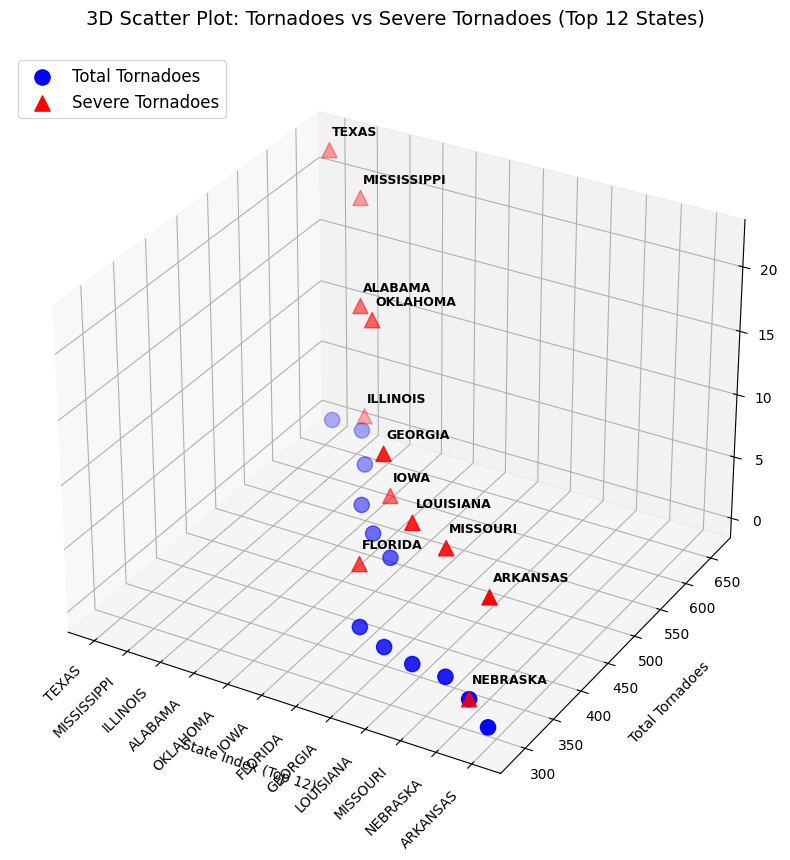

In [21]:
# Tornado vs Severe Tornados in top 12 states 
states_12 = states[:12]
t_counts_12 = t_counts[:12]
s_counts_12 = s_counts[:12]

# Numeric x-positions for each state
x_pos = np.arange(len(states_12))
y_total = np.array(t_counts_12)
z_severe = np.array(s_counts_12)

# Create figure
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')


# Scatter: Total Tornadoes

ax.scatter(
    x_pos,
    y_total,
    np.zeros_like(z_severe),
    s=120,
    c='blue',
    marker='o',
    label="Total Tornadoes"
)


# Scatter: Severe Tornadoes

ax.scatter(
    x_pos,
    y_total,
    z_severe,
    s=120,
    c='red',
    marker='^',
    label="Severe Tornadoes"
)


# Add State Labels

for i, state in enumerate(states_12):
    ax.text(
        x_pos[i],
        y_total[i] + 5,
        z_severe[i] + 1,
        state,
        fontsize=9,
        fontweight='bold'
    )


# Axis Labels

ax.set_xlabel("State Index (Top 12)", labelpad=12)
ax.set_ylabel("Total Tornadoes", labelpad=12)
ax.set_zlabel("Severe Tornadoes", labelpad=12)

# X-ticks with state names
ax.set_xticks(x_pos)
ax.set_xticklabels(states_12, rotation=45, ha="right")


# Title

ax.set_title(
    "3D Scatter Plot: Tornadoes vs Severe Tornadoes (Top 12 States)",
    fontsize=14,
    pad=20
)

# Legend
ax.legend(loc="upper left", fontsize=12)

plt.tight_layout()
plt.show()


In [22]:
sc.stop()